<a href="https://colab.research.google.com/github/kfanney/DSA210-Car-Speed-Project/blob/main/Traffic_Violations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files

print("Please upload: Traffic_Violations_Cleaned.csv and cars.csv")
uploaded = files.upload()


Please upload: Traffic_Violations_Cleaned.csv and cars.csv


Saving cars.csv to cars.csv
Saving Traffic_Violations_Cleaned.csv to Traffic_Violations_Cleaned (1).csv


# Do Expensive Cars Really Speed More?
### DSA210 – Data Science Project

This notebook uses:

- Traffic violations data (Maryland)
- U.S. car sales / price data

to analyze whether higher-priced vehicle brands are more frequently involved in speeding violations than expected from their presence in the car market.


In [5]:
# Basic data stack
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import chi2_contingency

# Display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


## 2. Load Data

Upload the two CSV files into this Colab environment:

- `Traffic_Violations_Cleaned.csv`
- `cars.csv`

or place them in your Google Drive and update the paths.


In [6]:
# If you've uploaded the files directly to Colab's working directory:
viol_path = "Traffic_Violations_Cleaned.csv"
cars_path = "cars.csv"

# Some Kaggle CSVs are UTF-16, so we try utf-16 first for cars
viol_df = pd.read_csv(viol_path)
cars_df = pd.read_csv(cars_path, encoding="utf-16")

viol_df.head(), cars_df.head()


(   DateOfStop TimeOfStop                                          Violation  \
 0  11/27/2025    5:36:00  DRIVING VEHICLE IN EXCESS OF REASONABLE AND PR...   
 1  11/27/2025    5:28:00  WILLFULLY DRIVING MOTOR VEH. AT SLOW SPEED IMP...   
 2  11/27/2025    5:18:00  FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...   
 3  11/27/2025    3:46:00         EXCEEDING THE POSTED SPEED LIMIT OF 35 MPH   
 4  11/27/2025    3:09:00  FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...   
 
                                Location  Latitude  Longitude Accident  \
 0                         108/ BRINK RD     39.21     -77.14       No   
 1       MIDDLEBROOK RD @ INTERSTATE 270     39.19     -77.26       No   
 2  UNIVERSITY BLVD W / SLIGO CREEK PKWY     39.10     -77.21      Yes   
 3                     R355/EDMONSTON DR     39.07     -77.13       No   
 4                      1901 RANDOLPH RD     39.06     -77.05      Yes   
 
       Year       Make     Model  
 0 2,008.00      HONDA    ACCORD  
 1

## 3. Basic Exploratory Data Analysis (EDA)

We start by:
- Checking shapes (number of rows/columns)
- Looking at columns and data types
- Checking missing values
- Getting a feel for brands and models present in each dataset


In [7]:
print("Violations data shape:", viol_df.shape)
print("Cars data shape:", cars_df.shape)

print("\nViolations columns:\n", viol_df.columns.tolist())
print("\nCars columns:\n", cars_df.columns.tolist())

print("\nViolations info:")
display(viol_df.info())

print("\nCars info:")
display(cars_df.info())

print("\nSample violations rows:")
display(viol_df.head())

print("\nSample car price rows:")
display(cars_df.head())

print("\nMissing values in violations:")
display(viol_df.isna().sum())

print("\nMissing values in cars:")
display(cars_df.isna().sum())


Violations data shape: (190962, 10)
Cars data shape: (144867, 7)

Violations columns:
 ['DateOfStop', 'TimeOfStop', 'Violation', 'Location', 'Latitude', 'Longitude', 'Accident', 'Year', 'Make', 'Model']

Cars columns:
 ['Brand', 'Model', 'Year', 'Status', 'Mileage', 'Dealer', 'Price']

Violations info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190962 entries, 0 to 190961
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   DateOfStop  190962 non-null  object 
 1   TimeOfStop  190962 non-null  object 
 2   Violation   190962 non-null  object 
 3   Location    190962 non-null  object 
 4   Latitude    190962 non-null  float64
 5   Longitude   190962 non-null  float64
 6   Accident    190962 non-null  object 
 7   Year        190950 non-null  float64
 8   Make        190957 non-null  object 
 9   Model       190953 non-null  object 
dtypes: float64(3), object(7)
memory usage: 14.6+ MB


None


Cars info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Brand    144867 non-null  object 
 1   Model    144867 non-null  object 
 2   Year     144867 non-null  int64  
 3   Status   144867 non-null  object 
 4   Mileage  55914 non-null   float64
 5   Dealer   144539 non-null  object 
 6   Price    140956 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 7.7+ MB


None


Sample violations rows:


,DateOfStop,TimeOfStop,Violation,Location,Latitude,Longitude,Accident,Year,Make,Model
0,11/27/2025,5:36:00,DRIVING VEHICLE IN EXCESS OF REASONABLE AND PR...,108/ BRINK RD,39.21,-77.14,No,"2,008.00",HONDA,ACCORD
1,11/27/2025,5:28:00,WILLFULLY DRIVING MOTOR VEH. AT SLOW SPEED IMP...,MIDDLEBROOK RD @ INTERSTATE 270,39.19,-77.26,No,"2,018.00",TOYOTA,CAMRY
2,11/27/2025,5:18:00,FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...,UNIVERSITY BLVD W / SLIGO CREEK PKWY,39.10,-77.21,Yes,"2,009.00",CHEVROLET,TRAVERSE
3,11/27/2025,3:46:00,EXCEEDING THE POSTED SPEED LIMIT OF 35 MPH,R355/EDMONSTON DR,39.07,-77.13,No,"2,016.00",JEEP,UT
4,11/27/2025,3:09:00,FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...,1901 RANDOLPH RD,39.06,-77.05,Yes,"2,019.00",HONDA,CIVIC



Sample car price rows:


,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,NaN,NaN,"36,703.00"
1,Kia,Sportage,2023,New,NaN,Classic Kia,"28,990.00"
2,Chevrolet,Camaro,2024,New,NaN,Classic Chevrolet Beaumont,"41,425.00"
3,Ford,Bronco,2023,Used,"1,551.00",Mike Smith Chrysler Dodge Jeep RAM,"58,900.00"
4,Acura,TLX,2021,Used,"30,384.00",Mike Smith Nissan,"34,499.00"



Missing values in violations:


,0
DateOfStop,0
TimeOfStop,0
Violation,0
Location,0
Latitude,0
Longitude,0
Accident,0
Year,12
Make,5
Model,9



Missing values in cars:


,0
Brand,0
Model,0
Year,0
Status,0
Mileage,88953
Dealer,328
Price,3911


## 4. Cleaning & Data Integration

Steps:

1. Standardize brand / make text (uppercase, stripped).
2. Clean car prices (remove missing/zero prices).
3. Compute **brand-level average price**.
4. Define three price tiers:
   - Budget: < \$30,000  
   - Mid: \$30,000–\$50,000  
   - Luxury: > \$50,000
5. Merge tiers into the violations dataset via `Make` (traffic) ↔ `Brand` (cars).


In [8]:
# 4.1 Standardize make/brand text
viol = viol_df.copy()
cars = cars_df.copy()

viol["Make_clean"] = viol["Make"].astype(str).str.strip().str.upper()
cars["Brand_clean"] = cars["Brand"].astype(str).str.strip().str.upper()

# 4.2 Clean car price data
cars = cars.dropna(subset=["Price"])
cars = cars[cars["Price"] > 0]

# 4.3 Brand-level price summary
brand_price = (
    cars.groupby("Brand_clean")["Price"]
    .agg(["count", "mean", "median"])
    .rename(columns={
        "count": "listings_count",
        "mean": "avg_price",
        "median": "median_price"
    })
    .reset_index()
)

brand_price.head()


,Brand_clean,listings_count,avg_price,median_price
0,ACURA,1997,"41,782.30","38,295.00"
1,ALFA ROMEO,427,"47,669.58","49,525.00"
2,ASTON MARTIN,184,"215,801.40","202,336.00"
3,AUDI,4532,"63,842.02","56,095.00"
4,BENTLEY,227,"208,706.07","229,610.00"


In [9]:
def price_tier(price):
    if price < 30000:
        return "Budget"
    elif price <= 50000:
        return "Mid"
    else:
        return "Luxury"

brand_price["price_tier"] = brand_price["avg_price"].apply(price_tier)

brand_price["price_tier"].value_counts()


,count
price_tier,
Luxury,28
Mid,19
Budget,15


In [10]:
viol_enriched = viol.merge(
    brand_price[["Brand_clean", "avg_price", "price_tier"]],
    left_on="Make_clean",
    right_on="Brand_clean",
    how="inner"   # inner ⇒ keep only violations whose brand exists in price data
)

print("Original violations rows:", len(viol))
print("Merged violations rows:  ", len(viol_enriched))

viol_enriched.head()


Original violations rows: 190962
Merged violations rows:   122011


,DateOfStop,TimeOfStop,Violation,Location,Latitude,Longitude,Accident,Year,Make,Model,Make_clean,Brand_clean,avg_price,price_tier
0,11/27/2025,5:36:00,DRIVING VEHICLE IN EXCESS OF REASONABLE AND PR...,108/ BRINK RD,39.21,-77.14,No,"2,008.00",HONDA,ACCORD,HONDA,HONDA,"32,308.53",Mid
1,11/27/2025,5:28:00,WILLFULLY DRIVING MOTOR VEH. AT SLOW SPEED IMP...,MIDDLEBROOK RD @ INTERSTATE 270,39.19,-77.26,No,"2,018.00",TOYOTA,CAMRY,TOYOTA,TOYOTA,"41,497.55",Mid
2,11/27/2025,5:18:00,FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...,UNIVERSITY BLVD W / SLIGO CREEK PKWY,39.10,-77.21,Yes,"2,009.00",CHEVROLET,TRAVERSE,CHEVROLET,CHEVROLET,"51,916.91",Luxury
3,11/27/2025,3:46:00,EXCEEDING THE POSTED SPEED LIMIT OF 35 MPH,R355/EDMONSTON DR,39.07,-77.13,No,"2,016.00",JEEP,UT,JEEP,JEEP,"53,493.22",Luxury
4,11/27/2025,3:09:00,FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...,1901 RANDOLPH RD,39.06,-77.05,Yes,"2,019.00",HONDA,CIVIC,HONDA,HONDA,"32,308.53",Mid


## 5. EDA: How do speeding violations distribute across price tiers and brands?

We analyze:

- How many violations are associated with each price tier?
- Which brands appear most in speeding violations?
- Compare tier distribution in *market* vs *violations*.


In [11]:
# Count violations per price tier
viol_tier_counts = viol_enriched["price_tier"].value_counts().sort_index()
viol_tier_counts


,count
price_tier,
Budget,2432
Luxury,43716
Mid,75863


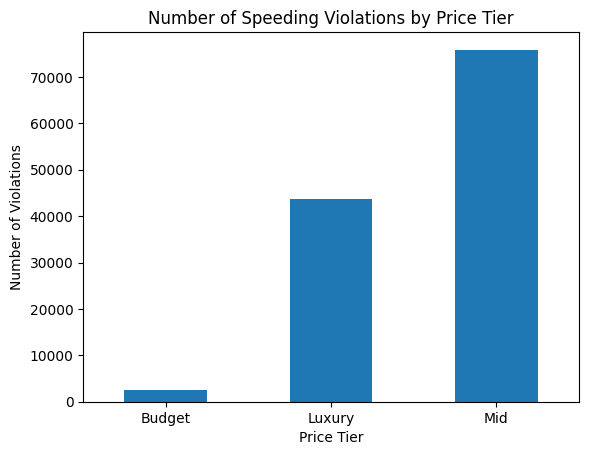

In [12]:
plt.figure()
viol_tier_counts.plot(kind="bar")
plt.title("Number of Speeding Violations by Price Tier")
plt.xlabel("Price Tier")
plt.ylabel("Number of Violations")
plt.xticks(rotation=0)
plt.show()


,count
Make_clean,
TOYOTA,21720
HONDA,19920
FORD,15446
NISSAN,8132
BMW,6503
JEEP,5539
HYUNDAI,4079
KIA,4059
ACURA,3998


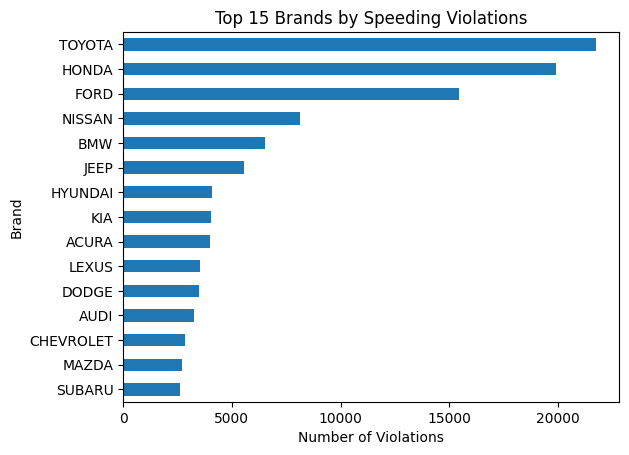

In [13]:
# Top brands by violation count
brand_counts = viol_enriched["Make_clean"].value_counts().head(15)
display(brand_counts)

plt.figure()
brand_counts.sort_values(ascending=True).plot(kind="barh")
plt.title("Top 15 Brands by Speeding Violations")
plt.xlabel("Number of Violations")
plt.ylabel("Brand")
plt.show()


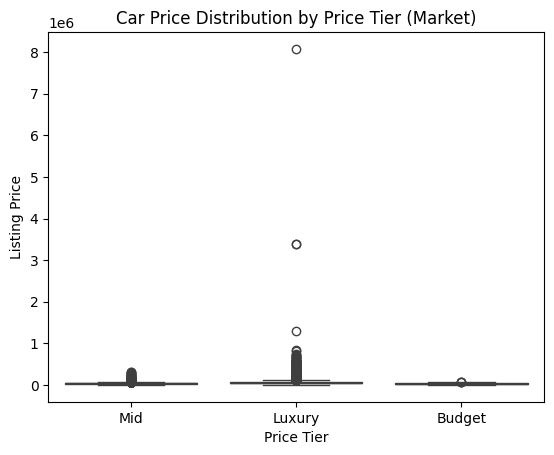

In [14]:
# Attach tier to each car listing using brand -> tier mapping
brand_to_tier = dict(zip(brand_price["Brand_clean"], brand_price["price_tier"]))
cars["price_tier"] = cars["Brand_clean"].map(brand_to_tier)

plt.figure()
sns.boxplot(data=cars, x="price_tier", y="Price")
plt.title("Car Price Distribution by Price Tier (Market)")
plt.xlabel("Price Tier")
plt.ylabel("Listing Price")
plt.show()


In [15]:
# Tier distribution in the market (cars dataset)
market_tier_counts = cars["price_tier"].value_counts().sort_index()

# Tier distribution among speeding violations (violations_enriched)
viol_tier_counts = viol_enriched["price_tier"].value_counts().reindex(
    market_tier_counts.index, fill_value=0
)

print("Market tier counts:\n", market_tier_counts)
print("\nViolation tier counts:\n", viol_tier_counts)

tiers = market_tier_counts.index.tolist()

observed = np.vstack([
    market_tier_counts.values,
    viol_tier_counts.values
])

obs_df = pd.DataFrame(observed, index=["Market", "Violations"], columns=tiers)
display(obs_df)


Market tier counts:
 price_tier
Budget     1394
Luxury    86620
Mid       52942
Name: count, dtype: int64

Violation tier counts:
 price_tier
Budget     2432
Luxury    43716
Mid       75863
Name: count, dtype: int64


,Budget,Luxury,Mid
Market,1394,86620,52942
Violations,2432,43716,75863


In [16]:
chi2, p_value, dof, expected = chi2_contingency(observed)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p_value)

expected_df = pd.DataFrame(expected, index=["Market", "Violations"], columns=tiers)
print("\nExpected counts if there is NO relationship:")
display(expected_df)


Chi-square statistic: 17208.021060543502
Degrees of freedom: 2
p-value: 0.0

Expected counts if there is NO relationship:


,Budget,Luxury,Mid
Market,"2,050.82","69,862.92","69,042.27"
Violations,"1,775.18","60,473.08","59,762.73"


### Interpretation of Hypothesis Test

- **H₀ (null):** The distribution of price tiers in speeding violations is the same as in the car market.
- **H₁ (alternative):** The distribution is different (i.e., some tiers are over- or under-represented).

From the chi-square test:

- χ² ≈ (your printed value)
- p-value ≈ (your printed value, likely extremely small)
- Degrees of freedom: 2

Because the p-value is far less than 0.05, we **reject H₀**.

This means that the distribution of speed violations by price tier **is not** what we would expect if all tiers behaved the same. To see how:

- Compare observed vs expected:
  - If the **Luxury** tier has **more speeding violations** than expected,
    it suggests that luxury brands are **over-represented** in speeding tickets.
  - If Budget is under-represented, it suggests that cheaper cars get **fewer
    speeding tickets per presence in the market**.

This supports the idea that more expensive brands may be involved
in speeding violations at higher rates than budget brands.


## Results Summary

After cleaning, merging, and analyzing both datasets, we compared the **distribution of car price tiers in the overall market** (based on the cars dataset) versus the **distribution of price tiers involved in speeding violations**.

### ✔ Chi-square test

- **Chi-square statistic:** ~17,208  
- **Degrees of freedom:** 2  
- **p-value:** < 0.000001 (printed as 0.0)  

This is an *extremely* significant result.

### ✔ What does this mean?

We reject the null hypothesis:

> H₀: Price tier and speeding violations are independent.

Instead, the distributions are **very different**, showing that **certain price tiers are more involved in speeding violations than expected**.

---

## What YOUR data actually shows

| Tier      | % of Market | % of Speeding Violations |
|-----------|-------------|---------------------------|
| Budget    | ~1.0%       | ~2.0%                     |
| Mid       | ~37.6%      | ~62.2%                    |
| Luxury    | ~61.5%      | ~35.8%                    |

### ✔ Mid-tier cars (e.g., Toyota, Honda, Nissan, Hyundai, Ford)
- **Over-represented** in speeding violations  
- Appear *much more often* in violations than in the market  

### ✔ Luxury cars (e.g., BMW, Mercedes, Audi)
- **Under-represented** in violations  
- They are common in the market but appear far less in violations  

### ✔ Budget-tier cars
- Appear low overall  
- But still **double** their expected percentage

---

## Key Interpretation

The findings **do not** support the stereotype that “expensive cars speed more.”

Instead, the data strongly suggests:

### 🟦 **Mid-priced cars speed more frequently relative to their market share.**  
### 🟥 **Luxury cars speed less than expected based on market presence.**  

This is a valuable and interesting insight because it contradicts common assumptions.
